In [2]:
from pathlib import Path
BASE_PATH = Path("/home/anto/Downloads/3dim_res")
EXP_TIMESTAMP = "1683636212.3794007"

In [3]:
import pandas as pd
from budgetsvm import optimization

df = pd.read_json(BASE_PATH / f"results/{EXP_TIMESTAMP}.json")

df["budget_percentage"] = df["model_name"].apply(
    lambda x: float(x.split("_")[0]) if "full" not in x else 1.0
)

total_train_time_sec = df.train_time.sum()
df.train_time = df.train_time.div(60)
df = df.rename({"train_time": "train_time_min"}, axis=1)

df_success = df.drop_duplicates(subset=["dataset", "model_name", "score"]).dropna().copy()
# df_success = df.copy()
# df_success["score"] = df_success.score.apply(lambda x: x if type(x)==float else "0.0")

df_success = df_success.astype(
    {
        "dataset": "string",
        "model_name": "string",
        "optimal": "bool",
        "params": "object",
        "score": "float",
        "budget": "float",
        "num_sv": "float",
        "train_time_min": "float",
    }
)


full_budget_score = df_success.query("budget==inf")[["dataset", "score"]]
df_success = df_success.join(
    full_budget_score.set_index("dataset"), on="dataset", rsuffix="_full_budget"
)
df_success["score_ratio"] = df_success["score"] / df_success["score_full_budget"]

df_success.query("dataset == '358b2eae819d51fd894ac568be097d90'")

,dataset,model_UUID,model_name,optimal,params,score,budget,num_sv,train_time_min,budget_percentage,score_full_budget,score_ratio
0,358b2eae819d51fd894ac568be097d90,4029cfb3-e2b7-40e9-bdcc-9a8fa3151e98,full_budget,True,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.710833,inf,5600.0,115.118329,1.0,0.710833,1.000000
1,358b2eae819d51fd894ac568be097d90,d8870e4b-b838-4efe-b840-c201051e43f1,0.90_budget,False,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.678750,5040.0,5040.0,116.329630,0.9,0.710833,0.954865
2,358b2eae819d51fd894ac568be097d90,3671ba6e-bffd-4598-8dfe-896274552083,0.80_budget,False,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.573750,4480.0,4479.0,117.433923,0.8,0.710833,0.807151
3,358b2eae819d51fd894ac568be097d90,84ab6a05-8d40-4cdf-9786-47b9c4a04f40,0.70_budget,False,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.546667,3919.0,3919.0,121.094167,0.7,0.710833,0.769050
4,358b2eae819d51fd894ac568be097d90,f723ffce-41cb-478c-9cd7-d93717f58037,0.60_budget,True,"{'C': 1, 'kernel': 'PrecomputedKernel(Gaussian...",0.886250,3360.0,1215.0,136.871868,0.6,0.710833,1.246776
5,358b2eae819d51fd894ac568be097d90,5065c18c-848b-4bf4-b407-c38487b47783,0.50_budget,True,"{'C': 1, 'kernel': 'PrecomputedKernel(Gaussian...",0.886250,2800.0,1215.0,137.791253,0.5,0.710833,1.246776
19,358b2eae819d51fd894ac568be097d90,79866655-332a-4d9e-8005-1623ac299092,0.40_budget,True,"{'C': 1, 'kernel': 'PrecomputedKernel(Gaussian...",0.886250,2240.0,1215.0,139.771982,0.4,0.710833,1.246776
20,358b2eae819d51fd894ac568be097d90,5c73fb62-3899-4820-b90d-d5f29aeaa6b0,0.30_budget,True,"{'C': 1, 'kernel': 'PrecomputedKernel(Gaussian...",0.886250,1680.0,1215.0,135.524480,0.3,0.710833,1.246776


5600 SV su dataset da 8000 punti?

In [4]:
import datetime

print(f"{datetime.timedelta(seconds=total_train_time_sec)} tot. training time")

2 days, 10:02:50.239652 tot. training time


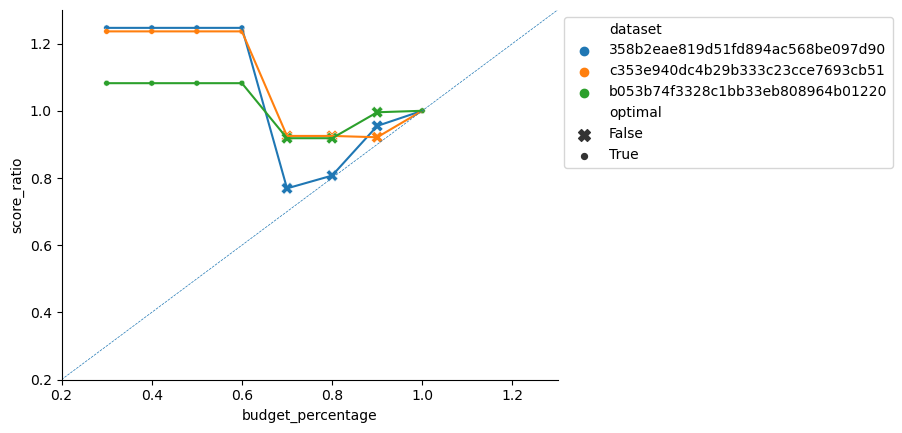

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

sns.lineplot(
    data=df_success,
    x="budget_percentage",
    y="score_ratio",
    hue="dataset",
    orient="x",
    legend=False,
    ax=ax,
)
g = sns.scatterplot(
    data=df_success,
    x="budget_percentage",
    y="score_ratio",
    hue="dataset",
    style="optimal",
    size="optimal",
    markers={True: "o", False: "X"},
    ax=ax,
)
plt.axline((0, 0), (1, 1), linestyle="--", linewidth=0.5)

ax.set(xlim=(0.2, 1.3))
ax.set(ylim=(0.2, 1.3))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

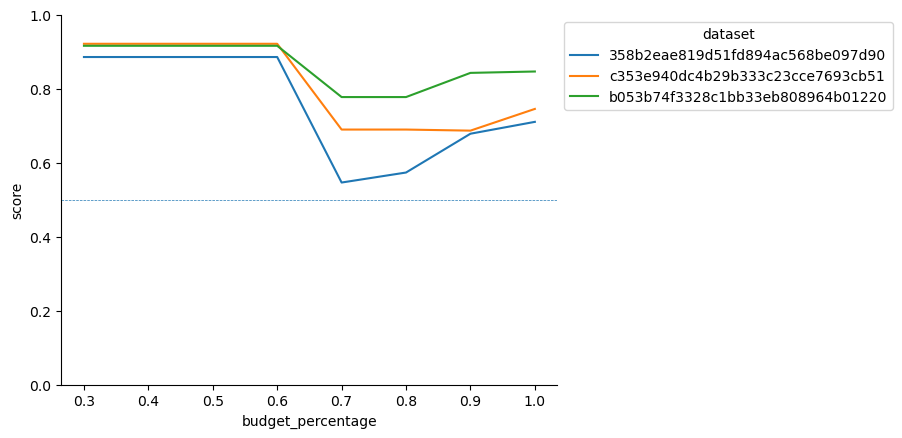

In [6]:
g = sns.lineplot(data=df_success, x="budget_percentage", y="score", hue="dataset")

plt.axhline(y=.5, linestyle="--", linewidth=.5)

g.set(ylim=(0.0, 1.0));

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

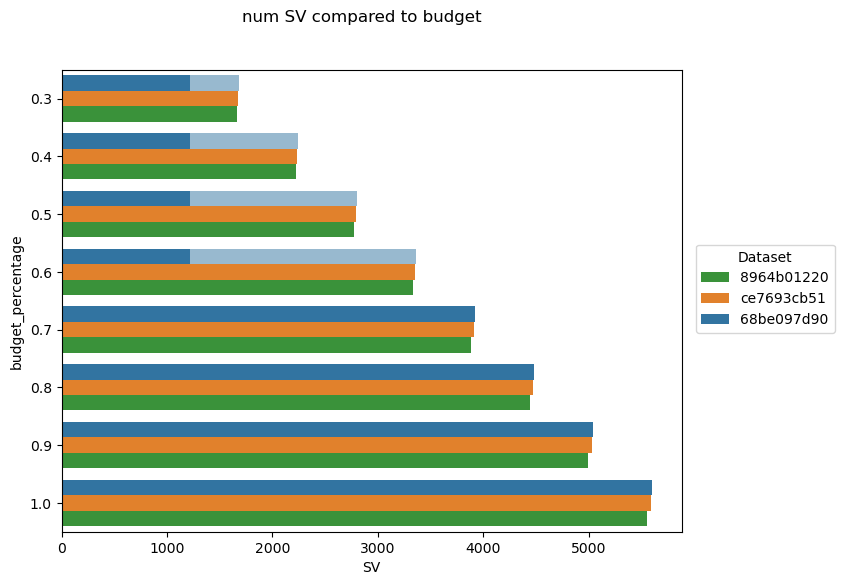

In [7]:
fig, ax = plt.subplots(figsize=(8,6))

sns.barplot(
    data=df_success,
    x="budget",
    y="budget_percentage",
    hue="dataset",
    orient="h",
    ax=ax
)
for bar in ax.containers[0]:
    bar.set_alpha(.5)
    
sns.barplot(
    data=df_success,
    x="num_sv",
    y="budget_percentage",
    hue="dataset",
    orient="h",
    ax=ax
)
ax.legend_.remove()
ax.set_xlabel("SV")

handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles[::-1], labels[::-1]):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
fig.legend(newHandles, [x[-10:] for x in newLabels], bbox_to_anchor=(.6, 0., 0.5, 0.6), title="Dataset")

fig.suptitle("num SV compared to budget")
plt.show()

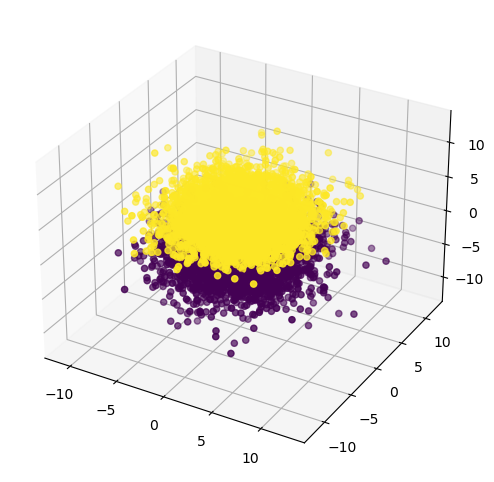

358b2eae819d51fd894ac568be097d90
{'complexities': {'c1': 0.0,
                  'c2': 0.0,
                  'clsCoef': 0.341,
                  'density': 0.849,
                  'f1': 0.231,
                  'f1v': 0.131,
                  'f2': 0.032,
                  'f3': 0.133,
                  'f4': 0.132,
                  'hubs': 0.757,
                  'l1': 0.021,
                  'l2': 0.019,
                  'l3': 0.003,
                  'lsc': 0.939,
                  'n1': 0.012,
                  'n2': 0.441,
                  'n3': 0.021,
                  'n4': 0.004,
                  't1': 0.065,
                  't2': 0.0,
                  't3': 0.0,
                  't4': 1.0},
 'n_features': 3,
 'n_samples': 8000,
 'prior_probability': [0.5, 0.5],
 'score': 0.233}


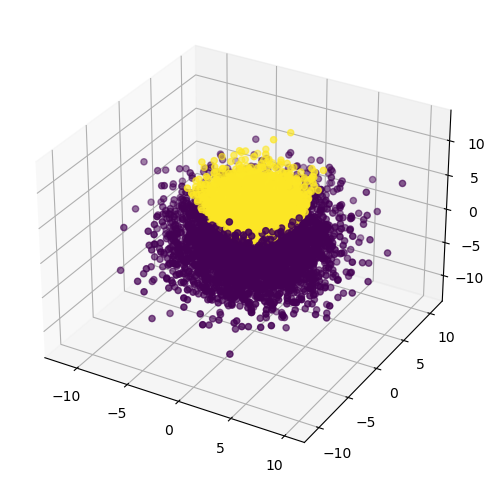

c353e940dc4b29b333c23cce7693cb51
{'complexities': {'c1': 0.0,
                  'c2': 0.0,
                  'clsCoef': 0.29,
                  'density': 0.791,
                  'f1': 0.378,
                  'f1v': 0.233,
                  'f2': 0.075,
                  'f3': 0.678,
                  'f4': 0.621,
                  'hubs': 0.651,
                  'l1': 0.155,
                  'l2': 0.171,
                  'l3': 0.109,
                  'lsc': 0.949,
                  'n1': 0.01,
                  'n2': 0.438,
                  'n3': 0.019,
                  'n4': 0.037,
                  't1': 0.054,
                  't2': 0.0,
                  't3': 0.0,
                  't4': 1.0},
 'n_features': 3,
 'n_samples': 8000,
 'prior_probability': [0.5, 0.5],
 'score': 0.303}


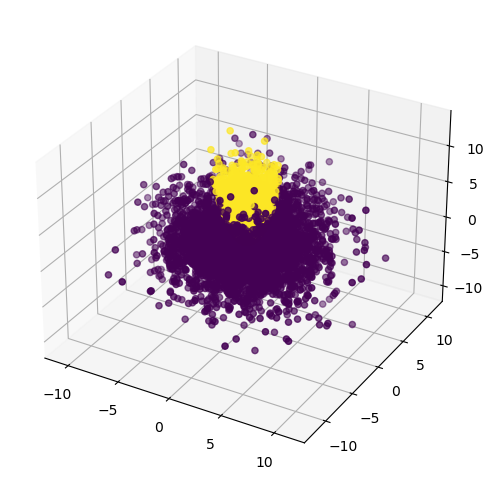

b053b74f3328c1bb33eb808964b01220
{'complexities': {'c1': 0.0,
                  'c2': 0.0,
                  'clsCoef': 0.254,
                  'density': 0.753,
                  'f1': 0.449,
                  'f1v': 0.289,
                  'f2': 0.037,
                  'f3': 0.733,
                  'f4': 0.591,
                  'hubs': 0.576,
                  'l1': 0.183,
                  'l2': 0.209,
                  'l3': 0.154,
                  'lsc': 0.951,
                  'n1': 0.007,
                  'n2': 0.432,
                  'n3': 0.012,
                  'n4': 0.033,
                  't1': 0.036,
                  't2': 0.0,
                  't3': 0.0,
                  't4': 1.0},
 'n_features': 3,
 'n_samples': 8000,
 'prior_probability': [0.5, 0.5],
 'score': 0.305}


In [8]:
from experiments.synthetic_datasets.common import load_dataset
from pprint import pprint
import matplotlib.pyplot as plt

for ds_id in df_success["dataset"].unique().tolist():
    ds = load_dataset(BASE_PATH / f"synthetic_datasets/datasets/{ds_id}.json")
    
    plt.figure(figsize = (10, 6))
    plot_axes = plt.axes(projection = '3d')
    plot_axes.scatter3D(*ds.X.T, c = ds.y)
    
    plt.show()
    
    print(ds_id)
    pprint(ds.complexity_report)

# sklearn

In [10]:
from sklearn.svm import SVC as sklearnSVC
from experiments.utils import Timer
# default_gamma = 1 / (len(X_train[0]) * np.var(X_train))

res = []
for ds_id in df_success.dataset.unique():
    ds = load_dataset(Path(BASE_PATH / f"synthetic_datasets/datasets/{ds_id}.json"))

    with Timer() as t:
        sklearn_model = sklearnSVC(C=1.0, kernel="rbf")
        sklearn_model.fit(ds.X_train, ds.y_train)
    res.append({
        "dataset": ds_id,
        "score": sklearn_model.score(ds.X_test, ds.y_test),
        "num_sv": sum(sklearn_model.n_support_),
        "train_time":t.time
    })

sklearn_df = pd.DataFrame(res)

res = df_success.query("model_name=='full_budget'")[['dataset','score', 'num_sv', 'train_time_min']]\
         .rename({"train_time_min": "train_time"}, axis=1)\
         .set_index("dataset")\
         .join(sklearn_df.set_index("dataset"), rsuffix="_skl")

res["train_time"] *= 60
res[sorted(res.columns)]

,num_sv,num_sv_skl,score,score_skl,train_time,train_time_skl
dataset,,,,,,
358b2eae819d51fd894ac568be097d90,5600.0,589,0.710833,0.995000,6907.099724,0.181695
c353e940dc4b29b333c23cce7693cb51,5592.0,488,0.745833,0.982917,7208.408405,0.159887
b053b74f3328c1bb33eb808964b01220,5550.0,475,0.847083,0.983333,7216.758462,0.165736


In [18]:
df_success.query("model_name == 'full_budget'")

,dataset,model_UUID,model_name,optimal,params,score,budget,num_sv,train_time_min,budget_percentage,score_full_budget,score_ratio
0,358b2eae819d51fd894ac568be097d90,4029cfb3-e2b7-40e9-bdcc-9a8fa3151e98,full_budget,True,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.710833,inf,5600.0,115.118329,1.0,0.710833,1.0
6,c353e940dc4b29b333c23cce7693cb51,8ba827d3-f206-4080-aaef-dc976d5cf5c1,full_budget,True,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.745833,inf,5592.0,120.140140,1.0,0.745833,1.0
12,b053b74f3328c1bb33eb808964b01220,2e7699b4-6b41-4443-8a03-bce39e236dbd,full_budget,True,"{'C': 10, 'kernel': 'PrecomputedKernel(Gaussia...",0.847083,inf,5550.0,120.279308,1.0,0.847083,1.0


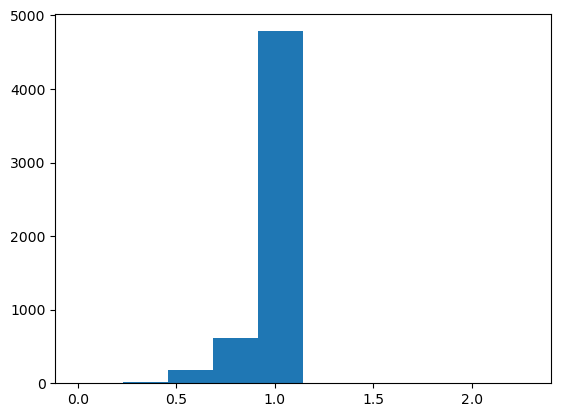

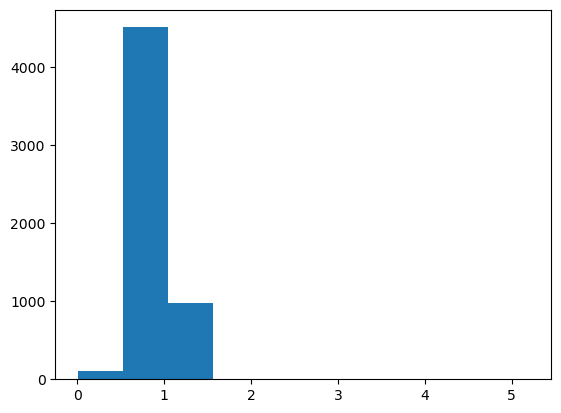

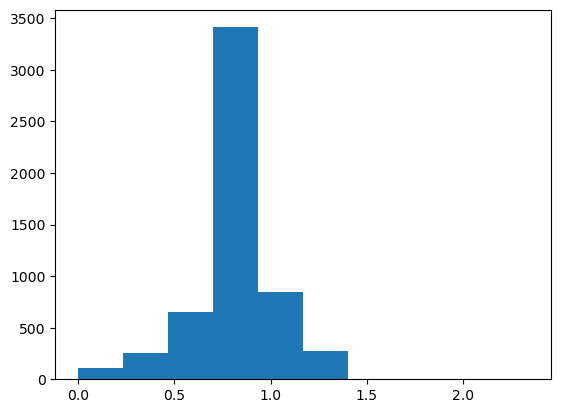

In [29]:
import pickle

for model_uuid in df_success.query("model_name == 'full_budget'")[["model_UUID"]].values.flatten():
    with open(BASE_PATH / "results" / "models" / f"{model_uuid}.pkl", "rb") as fp:
        model = pickle.load(fp)
        
        plt.hist(model.alpha_)
        plt.show()